In [86]:
import pandas as pd
from pypfopt import EfficientFrontier
from sklearn.covariance import ShrunkCovariance
import os
import numpy as np
import matplotlib.pyplot as plt

In [33]:
data = pd.read_csv("features.csv")[65:]
data_test = pd.read_csv("results/lm_test.csv")
open_cols = [col for col in data.columns if "Open" in col]
coins = [col.split("_")[1] for col in open_cols]

In [59]:
log_ret_cols = [col for col in data.columns if "Log_RET" in col]
log_ret_pred_cols = [col for col in data_test.columns if "Log_RET" in col]
log_ret_pred_cols = [col for col in log_ret_pred_cols if "_pred" in col]

In [61]:
n_all = data.shape[0]

In [62]:
n_test = data_test.shape[0]

In [37]:
lookforward = 7

In [95]:
i = 0
df_ret_pred = data_test[log_ret_pred_cols][:-1]
df_ret_true = data_test[log_ret_cols][1:]

In [73]:
weightsV = []
for i in range(0, n_test-1):
    df_cov = data[log_ret_cols]
    df_ret_pred = data_test[log_ret_pred_cols][:-1]
    ret_for_cov = df_cov[0:n_all - i]
    ret_pred = df_ret_pred.iloc[i]
    cov = ShrunkCovariance().fit(ret_for_cov).covariance_
    #calculate the portfolio weights
    ef = EfficientFrontier(ret_pred, cov, weight_bounds=(0,1))
    weights = ef.max_sharpe(risk_free_rate=0)
    cleaned_weights = ef.clean_weights()
    weightsV.append(cleaned_weights)

<AxesSubplot: >

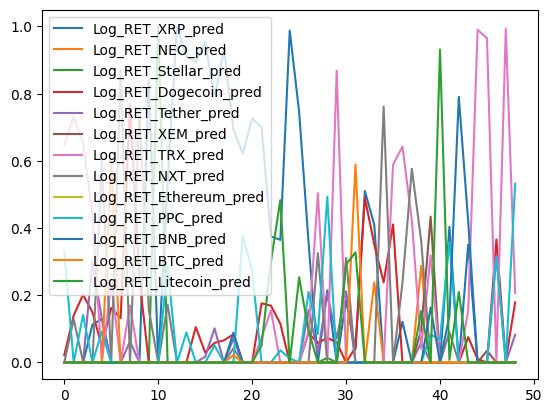

In [92]:
#plot the weights
weights_df = pd.DataFrame(weightsV)
weights_df.plot()

<AxesSubplot: >

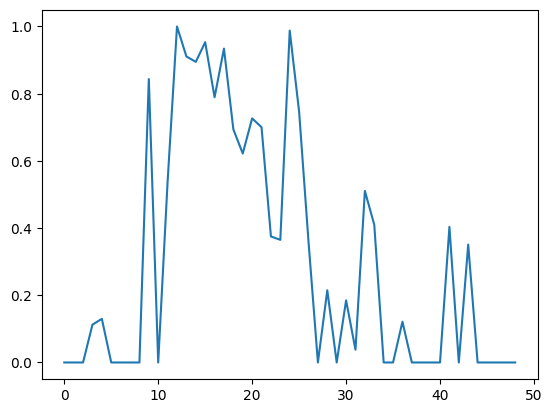

In [94]:
# plot the weights of only 1st coin
weights_df.iloc[:,0].plot()


In [110]:
df_ret_true.iloc[i] 

Log_RET_XRP        -0.005515
Log_RET_NEO         0.013410
Log_RET_Stellar     0.014199
Log_RET_Dogecoin    0.015775
Log_RET_Tether     -0.000100
Log_RET_XEM        -0.008435
Log_RET_TRX         0.007968
Log_RET_NXT        -0.029532
Log_RET_Ethereum   -0.011364
Log_RET_PPC        -0.035627
Log_RET_BNB         0.001099
Log_RET_BTC        -0.006924
Log_RET_Litecoin   -0.014200
Name: 1, dtype: float64

In [119]:
n_coins = len(coins)
weights_avg = np.ones(n_coins)/n_coins

In [120]:
#calculate the portfolio returns from the weights and df_ret_true
port_ret = []
for i in range(0, n_test-1):
    ret = np.dot(df_ret_true.iloc[i], weights_df.iloc[i])
    port_ret.append(ret) 
# portfolio of 1/n coins
port_ret_avg = []
for i in range(0, n_test-1):
    ret = np.dot(df_ret_true.iloc[i], weights_avg)
    port_ret_avg.append(ret)

In [123]:
#calculate cumulative returns
cum_ret = np.cumprod(1+np.array(port_ret))
cum_ret_avg = np.cumprod(1+np.array(port_ret_avg))

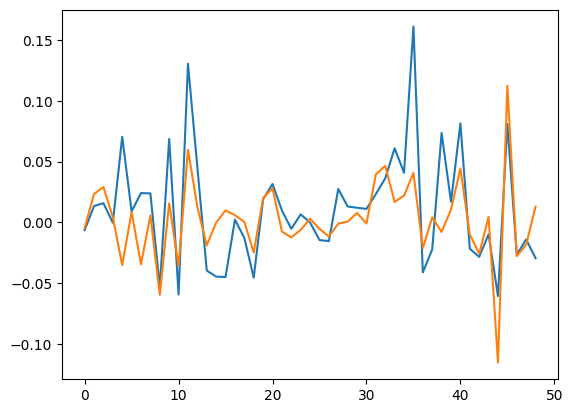

In [122]:
# plot portfolio returns
plt.plot(port_ret)
plt.plot(port_ret_avg)

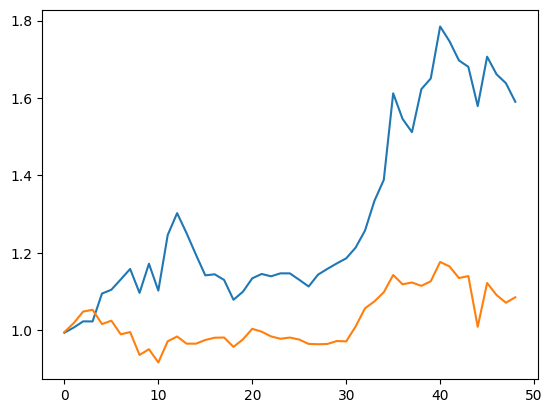

In [124]:
#plot cumulative returns
plt.plot(cum_ret)
plt.plot(cum_ret_avg)